# Assignment 1

**DS: 207 Introduction to Natural Language Processing**

**Due (Feb 6, 16:59 PM)**

Development & Design: Debarpan Bhattacharya & Nicy Scaria.

Testing: Kinshuk Vasisht

The goal of this assignment is introduce the basics of text processing, by building a few text classifiers, and learning to represent words.

You'll have to add your code wherever you see the comment `# ADD YOUR CODE HERE`. Please make a copy of this assignment, and you can use Google Colab notebooks to work on this. Later, you can download this notebook as a python file and submit it as per the following instructions.

## Submission Instructions:

1. In the notebook, a few example codes are provided, whereas a few are kept blank for you to fill them up.
2. The evaluation will be based on the results obtained by functions impleted by you. Do not change the print statements having `EVALUATION` as they are used for auto-evaluation.
3. **Submission file(s)**:
  
  * Save this `.ipynb` to your drive, complete the required code blocks and run the notebook.
  * After completing this assignment, download the notebook as`.py`. Name it as `SAPname_SRno_assignment1.py`, where `SAPname` refers to your name as per SAP record, and `SRno` refers to the last 5 digits of your IISc SR number. For example, IISc student with SAP name Twyla Linda (SR no - 04-03-00-10-22-20-1-15329) would name it as `Twyla_Linda_15329_assignment1.py`.
  *   The files associated with the Word2Vec training, i.e., the `model.pt`, `vocab.pt`, `word_embeddings.npy` and `loss.json`, will be downloaded and saved in a folder with the name `SAPname_SRno`. Zip this folder along with the `.py` file, save it as `SAPname_SRno_assigment1` and upload on MS Teams. The zip folder should contain: (1) `SAPname_SRno_assignment1.py`, (2) a subfolder called `SAPname_SRno` which will contain `model.pt`, `vocab.pt` , `word_embeddings.npy` and `loss.json`.


Because submissions are auto-graded, please ensure that the naming of the files is consistent with the instructions.

## Part I Text Classification (TA: Debarpan Bhattacharya)

**Dataset**:

We will dive into a basic text-based sentiment classification task. The dataset consists of sentences with two different kinds of sentiments- `positive`, and `negative` sentiments. Following are a set of examples,

* **`positive`**: *I really like your new haircut!*
* **`negative`**: *Your new haircut is awful!*

The Dataset has a training set (`train_data.csv`- provided), a validation set (`val_data.csv`- provided) and a blind test set (`test_data.csv`- not provided). The notebook uses a `test_data.csv` file, but it is just a duplicate of `val_data.csv`, and the blind `test_data.csv` will replace it while grading your solutions.

**Important**: Fix seed as 42 whenever performing any randomized operations, e.g., initializing ML models.


### Download the dataset required for the assignment

In [1]:
# download train data
!wget -O train_data.csv "https://docs.google.com/spreadsheets/d/176-KrOP8nhLpoW91UnrOY9oq_-I0XYNKS1zmqIErFsA/gviz/tq?tqx=out:csv&sheet=train_data.csv"

# download validation data
!wget -O val_data.csv "https://docs.google.com/spreadsheets/d/1YxjoAbatow3F5lbPEODToa8-YWvJoTY0aABS9zaXk-c/gviz/tq?tqx=out:csv&sheet=val_data.csv"

# download test data
!wget -O test_data.csv "https://docs.google.com/spreadsheets/d/1YxjoAbatow3F5lbPEODToa8-YWvJoTY0aABS9zaXk-c/gviz/tq?tqx=out:csv&sheet=val_data.csv"

--2026-01-16 10:22:59--  https://docs.google.com/spreadsheets/d/176-KrOP8nhLpoW91UnrOY9oq_-I0XYNKS1zmqIErFsA/gviz/tq?tqx=out:csv&sheet=train_data.csv
Resolving docs.google.com (docs.google.com)... 142.251.170.102, 142.251.170.139, 142.251.170.138, ...
Connecting to docs.google.com (docs.google.com)|142.251.170.102|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘train_data.csv’

train_data.csv          [          <=>       ]  15.12M  7.42MB/s    in 2.0s    

2026-01-16 10:23:04 (7.42 MB/s) - ‘train_data.csv’ saved [15851033]

--2026-01-16 10:23:04--  https://docs.google.com/spreadsheets/d/1YxjoAbatow3F5lbPEODToa8-YWvJoTY0aABS9zaXk-c/gviz/tq?tqx=out:csv&sheet=val_data.csv
Resolving docs.google.com (docs.google.com)... 142.251.170.102, 142.251.170.139, 142.251.170.138, ...
Connecting to docs.google.com (docs.google.com)|142.251.170.102|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/cs

In [2]:
#@title Read data
import numpy as np
import pandas as pd

df = pd.read_csv('train_data.csv')
df_val = pd.read_csv('val_data.csv')

# Note that we will change the test file
# when we grade assignments  ...
# For now it is the same as the validation set
df_test = pd.read_csv('test_data.csv')

df.head()

,review,sentiment
0,I've watched this documentary twice - and alth...,positive
1,This is probably the worst movie I've seen in ...,negative
2,Superb story of a dedicated young teacher who ...,positive
3,<br /><br />Spoilers<br /><br />I'm going to b...,negative
4,"What can be said, really... ""The Tenant"" is a ...",positive


In [3]:
#@title Prepare training, validation and test data.

X_train, y_train = df.review.values.tolist(), df.sentiment.values.tolist()
X_val, y_val = df_val.review.values.tolist(), df_val.sentiment.values.tolist()
X_test, y_test = df_test.review.values.tolist(), df_test.sentiment.values.tolist()

labels = ['negative', 'positive']

# converting the sentiment labels into labels
# class 0 for negagtive, and class 1 for positive
y_train = [labels.index(i) for i in y_train]
y_val = [labels.index(i) for i in y_val]
y_test = [labels.index(i) for i in y_test]

#### Approach 1: Rule based classification

The rule-based classification works using a few hand-crafted rules. In sentiment classification, few words are associated with positive sentiment and few others with negative sentiment. Let's attempt to build a classifier that predicts the sentiment of the reviews based on such words.

Let's first write a few rules to extract important features about the input movie review. As an example, we provide a function that counts the number of `good` and `bad` words in the input.

Below, you can see a sample rule-based classification system. Later, you will be building one yourself.

In [4]:
def sample_extract_features(X):
    """
    Extracts features from a text input.

    Args:
        X (string): Text input.

    Returns:
        dictionary: features extracted from X.
    """

    features = {}
    X_split = X.split(' ')

    # Count the number of "good words" and "bad words" in the text
    good_words = ['love', 'good', 'brilliant', 'fantastic', 'amazing', 'great']
    bad_words = ['hate', 'bad', 'horrible', 'awful', 'terrible', 'mess', 'frustating', 'frustatingly']

    features['good_word_count'], features['bad_word_count'] = 0, 0
    for x in X_split:
        if x in good_words:
            features['good_word_count'] = features.get('good_word_count', 0) + 1
        if x in bad_words:
            features['bad_word_count'] = features.get('bad_word_count', 0) + 1

    # The "bias" value can be set to one, to allow us to assign a "default" score to the text
    features['bias'] = 1
    return features

In [5]:
def sample_predict(X, feature_weights):
    """
    Classifies the sentiment of a text input.

    Args:
        X (string): Text input.
        feature_weights: weightage of different features.

    Returns:
        int: binary sentiment represented by 0/1.
    """

    score = 0

    # Here we just multiply the feature value
    # with its corresponding weight and aggregate
    for feat_name, feat_value in sample_extract_features(X).items():
        score = score + feat_value * feature_weights[feat_name]

    # the prediction is based on whether the aggregated score is above 0 or not
    if score > 0:
        return 1
    else:
        return 0

In [6]:
def get_sample_features_weights():
  """
    To obtain feature weightage for different features.

    Args:
        None here.

    Returns:
        dictionary: feature names and their weightage.
    """
  # Based on the selected features, you can manually assign them weights
  feature_weights = {'good_word_count': 1.0, 'bad_word_count': -1.0, 'bias': 0.5}
  return feature_weights

In [7]:
#@title Computing the accuracy of the system

def calculate_accuracy(Y_true, Y_pred):
    """
    Calculates accuracy of predictions given the ground truth.

    Args:
        Y_true (list): Ground truth labels.
        Y_pred (list): Predictions.

    Returns:
        float: Prediction accuracy in range [0.0-100.0].
    """
    correct = 0.0
    total = len(Y_true)

    # verify if we have the same number of predictions as labels
    assert len(Y_true) == len(Y_pred)

    # count the number of correct predictions
    for y_true, y_pred in zip(Y_true, Y_pred):
        if y_true == y_pred:
            correct += 1.0

    if total > 0:
        return 100. * correct / total

    # return 0 if there the total number of examples are zero
    return 0.0

In [8]:
#@title Putting the sample rule-based classifier together

# get the sample weights
sample_feature_weights = get_sample_features_weights()

predictions = []

# for each test example, make a prediction
for input_example in X_test:
    y = sample_predict(input_example, sample_feature_weights)
    predictions.append(y)

# compute and print the accuracy
print (calculate_accuracy(y_test, predictions))

60.5


As you can observe here, the model achieves about 60% accuracy (note that the performance of a random classifier would be close to 50%).

### Build your own rule-based classifier (10 marks)

Your have to write your own `extract_features`, `get_feature_weights` and `predict` functions for your rule-based classifier.

In [9]:
def isAllCaps(word):
    return word.isupper() and len(word) > 1

def extract_features(X):
    """
    Extracts features from a text input.

    Args:
        X (string): Text input.

    Returns:
        dictionary: features extracted from X.
    """
    features = {}
    features['bias'] = 1

    import re

    # --- lexicons (tweak freely) ---
    pos_words = {
        "love","loved","like","liked","great","amazing","awesome","fantastic","brilliant","excellent",
        "wonderful","best","perfect","enjoy","enjoyed","nice","good","beautiful","happy","superb"
    }
    neg_words = {
        "hate","hated","bad","awful","terrible","horrible","worst","boring","waste","poor",
        "disappointing","disappointed","annoying","mess","stupid","dull","ugly","sad","ridiculous","painful"
    }
    negators = {"not","no","never","n't","hardly","rarely"}
    intensifiers = {"very","really","so","extremely","quite","too","super"}

    # tokenize: lowercase words + keep contractions like "don't"
    tokens = re.findall(r"[a-z]+'t|[a-z]+", X.lower())

    # --- initialize ALL feature keys (important for LR block later) ---
    features["pos_word_count"] = 0
    features["neg_word_count"] = 0

    # count words + handle simple negation scope (previous token)
    prev = ""
    for t in tokens:
        multiplier = 1

        if prev in intensifiers:
            multiplier += 1
        if isAllCaps(prev):
            multiplier += 1
        if isAllCaps(t):
            multiplier += 1

        # Only count words that are in our sentiment lexicons.
        if t in pos_words:
            # flip if negation precedes a positive word: "not good" -> negative
            if prev in negators:
                features["neg_word_count"] += multiplier
            else:
                features["pos_word_count"] += multiplier
        elif t in neg_words:
            # flip if negation precedes a negative word: "not terrible" -> positive
            if prev in negators:
                features["pos_word_count"] += multiplier
            else:
                features["neg_word_count"] += multiplier

        prev = t

    return features

In [10]:
def get_feature_weights():
    return {'pos_word_count': 1.0, 'neg_word_count': -1.0, 'bias': 0.5}


In [11]:
def predict(X, feature_weights):
    feats = extract_features(X)
    score = 0.0

    for k, v in feats.items():
        score += v * feature_weights.get(k, 0.0)

    return 1 if score > 0 else 0


In [12]:
#@title Evaluating your rule-based classifier

## Please do not change anything in this code block.

feature_weights = get_feature_weights()

predictions = []

for input_example in X_test:
    y = predict(input_example, feature_weights)
    predictions.append(y)

print (f"EVALUATION of rule-based classifier is: {calculate_accuracy(y_test, predictions)}")

EVALUATION of rule-based classifier is: 66.8


You will be evaluated based on the performance of your rule-based classifier. Please note that the sample rule-based classifier achieves about 60% accuracy. Anything below 60% will not yield any points.

***Please do not change the evaluation code in the block above, as it would be used to grade your classifier***.

Below, we will directly learn the feature weights, rather than manually assigning those ourselves as manual assignment can be error-prone and labor intensive.

In [13]:
#@title Learning the weights of extracted features using logistic regression.

from sklearn.linear_model import LogisticRegression

def get_sample_learnable_weights(X_data, Y_data, sample_extract_features):
    """
    Learn feature weights using the training data.

    Args:
        X_data (list of strings): All the text data points in training data.
        Y_data (list of int): Ground truth labels for text data points in X_data.
        sample_extract_features: A Function that extracts features from text sample.
                                 The sample_extract_features function should be of the
                                 same format as sample_extract_features(X) function
                                 implemented above.

        Returns:
            dictionary: feature names and their learned weights.
    """
    # training a logistic regression model for classification using
    # the features obtained by sample_extract_features(X) function.

    # get all feature names
    feature_names = list(sample_extract_features(X_data[0]).keys())

    # Below code snippet accumulates features extracted from all the
    # text data points in X_data.
    all_features = []
    # iterate over all text data points in X_data.
    for input_example in X_data:
      feature = [] # to store features extracted from input_example.
      feat_dict = sample_extract_features(input_example)
      # iterate over different feature names and store the corresonding values.
      for name in feature_names:
        feature.append(feat_dict[name])
      all_features.append(feature) # append features obtained from input_example to all_features.

    # Below, we show how to fit a logistic regression (LR) model using the features and the target labels.
    # We use Sklearn's 'LogisticRegression' to do this. While initiating, 'fit_intercept' is set False,
    # because 'bias' is already included in the extracted feature (see sample_extract_features() implementation).
    # Also, random state is set to 42 to avoid different initialization of the model while running the codebook
    # multiple times.
    clf = LogisticRegression(fit_intercept=False, random_state=42).fit(all_features, Y_data)

    # As training a logistic regression model assigns weights to each of the features (refer class notes),
    # these weights are learnable and we will use them as learned feature weights.

    # extract feature weights.
    coffs = clf.coef_[0]

    # convert to dictionary
    coffs_dict = {feature_names[i]: coffs[i] for i in range(len(feature_names))}

    return coffs_dict

In [14]:
#@title Putting the sample rule-based classifier with learnable weights together

# get the sample weights
sample_feature_weights_lr = get_sample_learnable_weights(X_train, y_train, sample_extract_features)

predictions = []

for input_example in X_test:
    y = sample_predict(input_example, sample_feature_weights_lr)
    predictions.append(y)

print (calculate_accuracy(y_test, predictions))

63.775


As you can observe here, the model achieves about 63% accuracy (note that the performance of a random classifier would be close to 50%). Note that, the performance significantly improves by making the weights learnable as compared to the manual weights.

## How does learnable weights-based classifier work on the features you implemented (3 marks)

Your don't have to write anything here except simply running the below kernel.
Depending upon the quality of your features, your classifier performance will vary.

In [15]:
#@title Evaluating your rule-based classifier with learnable weights.

## Please do not change anything in this code block.
feature_weights_lr = get_sample_learnable_weights(X_train, y_train, extract_features)

predictions = []

for input_example in X_test:
    y = predict(input_example, feature_weights_lr)
    predictions.append(y)

print (f"EVALUATION of rule-based classifier with learnable weights is: {calculate_accuracy(y_test, predictions)}")

EVALUATION of rule-based classifier with learnable weights is: 76.6


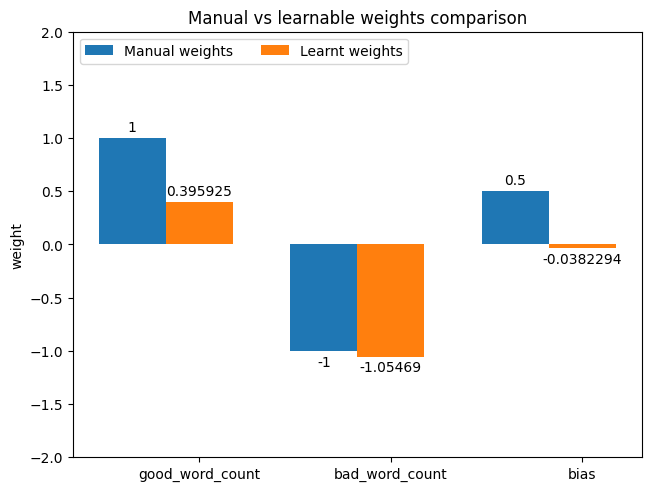

In [16]:
#@title Visualization and comparison between manual and learnable weights.

# visualize and compare the manual weights vs learnt weights.

import matplotlib.pyplot as plt
import numpy as np

feature_names = list(sample_feature_weights.keys())
manual_weights = [sample_feature_weights[name] for name in feature_names]
learnt_weights = [sample_feature_weights_lr[name] for name in feature_names]
weights_dict = {
    'Manual weights': manual_weights,
    'Learnt weights': learnt_weights,
}

x = np.arange(len(feature_names))  # the label locations
width = 0.35  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in weights_dict.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('weight')
ax.set_title('Manual vs learnable weights comparison')
ax.set_xticks(x + width, feature_names)
ax.legend(loc='upper left', ncols=2)
ax.set_ylim(-2, 2)

plt.savefig('manual_vs_learned_weights.png')
# Refer to the saved manual_vs_learned_weights.png to see how manual and learned weights compare.

### Approach 2: Bag-of-Words (BoW) (10 marks)

The BoW vector representations is based on the unordered counts of words piece of text (similar to a "bag" of words).

Let's attempt to build a classifier that tries to classify the reviews based on such vectors.

In [17]:
# implement your BoW classifier. In case the total number of words are very large,
# consider using top-k most frequent words (e.g. k=10,000) while creating BoW vectors.

# The below function finds out all words present in the corpus and assigns each word to
# an index.

def word_to_idx_BOW(X_data, K=10000):
    """
    Generates a set of word-index pairs after analyzing all words present in entire
    data corpus X_data.

    Args:
        X_data (list of strings): All the text data points in training data.
        K (int): The number of most frequent words to be considered.
                 In case (K-p)th to (K+q)th words in most frequent words order
                 have same frequency, you can choose p words randomly from those
                 (p+q) number of words.

        Returns:
            dictionary: words as keys and indices as values.
    """
    word_to_idx = {}
    # ADD YOUR CODE HERE
    for i in range(len(X_data)):
        words = X_data[i].split(' ')
        for word in words:
            if word not in word_to_idx:
                word_to_idx[word] = 0
            word_to_idx[word] += 1

        if len(word_to_idx) > K:
            break

    return word_to_idx

# generate BoW feature for text input X.
def extract_features_BoW(X, word_to_idx):
    """
    Generates BoW feature for X using word_to_idx.

    Args:
        X (string): text input.
        word_to_idx (dictionary): word-index mapping with words as keys and
                                  indices as values.

        Returns:
            dictionary: features of X.
    """
    features = {}
    # ADD YOUR CODE HERE
    words = X.split(' ')

    for word in words:
        if word in word_to_idx:
            idx = word_to_idx[word]
            features[idx] = features.get(idx, 0) + 1

    return features

In [18]:
# checking the outputs of the above functions on a small set of examples

sample_data = [
    "When is the homework due ?",
    "When are the TAs' office hours ?",
    "How hard is the homework ?",
]
word_to_idx = word_to_idx_BOW(sample_data)
features = extract_features_BoW(sample_data[0], word_to_idx)
print(features)

{2: 3, 3: 2, 1: 1}


In [19]:
def get_learnable_weights_BoW(X_data, Y_data, word_to_idx_BOW, extract_features_BoW):
    """
    Learning feature weights for BoW features, using training data.

    Args:
        X_data (list of strings): All the text data points in training data.
        Y_data (list of int): Ground truth labels for text data points in X_data.
        word_to_idx_BOW: A Function that looks at all the words in data corpus X_data
                         and returns word-index mapping. You had to implement
                         word_to_idx_BOW() funtion above.
        extract_features_BoW: A Function that extracts BoW features from text sample.
                              The extract_features_BoW() function had to be implemented
                              by you above.

        Returns:
            dictionary: feature names and their learned weights.
    """

    # Build a word->count mapping from corpus (word_to_idx_BOW may return counts)
    raw_word_counts = word_to_idx_BOW(X_data)

    # If the mapper already returns indices (unlikely in this implementation),
    # detect and convert counts->indices appropriately. We expect raw_word_counts
    # to be a dict word->count; convert to word->idx (0..V-1) sorted by freq.
    if raw_word_counts and all(isinstance(v, int) for v in raw_word_counts.values()):
        # sort words by frequency (descending)
        sorted_words = sorted(raw_word_counts.items(), key=lambda x: -x[1])
        word_list = [w for w, _ in sorted_words]
    else:
        # fallback: use keys as-is
        word_list = list(raw_word_counts.keys())

    # create final word->idx mapping
    word_to_idx = {w: i for i, w in enumerate(word_list)}

    # build feature matrix
    num_samples = len(X_data)
    vocab_size = len(word_to_idx)

    # avoid huge memory by using a dense list of lists; acceptable for assignment sizes
    all_features = []
    for text in X_data:
        feat_vec = [0] * vocab_size
        feat_dict = extract_features_BoW(text, word_to_idx)
        for idx, cnt in feat_dict.items():
            # idx might be int or string; ensure int
            try:
                i = int(idx)
            except Exception:
                # if idx is a word, map it
                i = word_to_idx.get(idx, None)
            if i is None:
                continue
            if 0 <= i < vocab_size:
                feat_vec[i] = cnt
        all_features.append(feat_vec)

    # train logistic regression on BoW features
    from sklearn.linear_model import LogisticRegression
    clf = LogisticRegression(fit_intercept=False, random_state=42, max_iter=1000)
    clf.fit(all_features, Y_data)

    coeffs = clf.coef_[0]

    # map index -> weight
    coffs_dict = {i: float(coeffs[i]) for i in range(len(coeffs))}

    # Return both the weights and the word_to_idx mapping so predict can use it
    return {'weights': coffs_dict, 'word_to_idx': word_to_idx}

In [20]:
def predict(X, feature_weights):
    """
    Classifies the sentiment of a text input.

    Args:
        X (string): Text input.
        feature_weights: weightage of different features.

    Returns:
        int: binary sentiment represented by 0/1.
    """
    # feature_weights is expected to be a dict returned by get_learnable_weights_BoW
    if not feature_weights:
        return 1

    if isinstance(feature_weights, dict) and 'weights' in feature_weights and 'word_to_idx' in feature_weights:
        weights = feature_weights['weights']
        word_to_idx = feature_weights['word_to_idx']
    else:
        # backward compatibility: if a raw weights dict keyed by indices was provided
        weights = feature_weights
        word_to_idx = {}

    feats = extract_features_BoW(X, word_to_idx)
    score = 0.0
    for idx, cnt in feats.items():
        try:
            i = int(idx)
        except Exception:
            i = word_to_idx.get(idx, None)
        if i is None:
            continue
        score += cnt * float(weights.get(i, 0.0))

    return 1 if score > 0 else 0

# get the sample weights
BoW_feature_weights_lr = get_learnable_weights_BoW(X_train, y_train, word_to_idx_BOW, extract_features_BoW)

predictions = []

for input_example in X_test:
    y = predict(input_example, BoW_feature_weights_lr)
    predictions.append(y)

print (f"EVALUATION of BoW classifier is: {calculate_accuracy(y_test, predictions)}")

EVALUATION of BoW classifier is: 84.275


## Finding most positive and most negative words (2 Marks)

Based on the magnitude of weights corresponding to different words, write down code to find the 5 most positive words and 5 most negative words.

In [21]:
most_positive_words = []
most_negative_words = []

## WRITE CODE HERE TO POPULATE THESE LISTS
## most_postive_words and most_negative_words should be list of strings

#get feature set
BoW_feature_weights_lr = get_learnable_weights_BoW(X_train, y_train, word_to_idx_BOW, extract_features_BoW)

# Extract word_to_idx mapping and weights from the learned feature weights
word_to_idx = BoW_feature_weights_lr['word_to_idx']
weights = BoW_feature_weights_lr['weights']

# Create a list of (word, weight) tuples
word_weights = []
# Iterate through the word_to_idx to get the word string and its corresponding weight
# We need to reverse the mapping from index to word for lookup
idx_to_word = {v: k for k, v in word_to_idx.items()}

for idx, weight in weights.items():
    word = idx_to_word.get(idx) # Get the word string using the index
    if word:
        word_weights.append((word, weight))

# Sort by weight in descending order for most positive words
word_weights_sorted_desc = sorted(word_weights, key=lambda item: item[1], reverse=True)

# Sort by weight in ascending order for most negative words
word_weights_sorted_asc = sorted(word_weights, key=lambda item: item[1])

# Get the top 5 most positive words
most_positive_words = [word for word, _ in word_weights_sorted_desc[:5]]

# Get the top 5 most negative words
most_negative_words = [word for word, _ in word_weights_sorted_asc[:5]]



assert (len(most_positive_words) == 5)
assert (len(most_negative_words) == 5)

print("EVALUATION five most positive words: " + " ".join(most_positive_words))
print("EVALUATION five most negative words: " + " ".join(most_negative_words))

EVALUATION five most positive words: wonderfully subtle />7/10 emotions brutal
EVALUATION five most negative words: waste poorly worst fails tedious


## Part II Word2Vec (TA: Nicy Scaria)  (25 Marks)

Word2vec is one of the most popular techniques to learn word embeddings. The idea behind word2vec was that the meaning of a word is determined by the context in which it occurs. A word embedding is a learned representation for text where words that have the same meaning have a similar representation.

**Word2vec** model has 2 architectures:

1. **Continuous bag of word (CBOW):**

    CBOW predicts the center word from the surrounding context words.

2. **Skip-gram:**

    Skip-gram predicts surrounding context words from the center word.

#### SkipGram from Scratch

In this exercise, you will code the skipgram model from scratch using the PyTorch library.

In [4]:
# Colab setup (run once): install torch + get WikiText-2 data (NO torchtext)

# Why: torchtext often fails on Colab/Python 3.12 due to binary ABI mismatches (libtorchtext.so errors).
# We'll avoid torchtext completely and use the raw WikiText-2 files.

import os
import sys
import subprocess
import time
import urllib.request
import zipfile

def _pip(*args):
    cmd = [sys.executable, "-m", "pip", *args]
    print("Running:", " ".join(cmd))
    subprocess.check_call(cmd)

# Remove torchtext if present (prevents accidental imports later).
_pip("uninstall", "-y", "torchtext", "libtorchtext")

# Ensure torch is installed (Colab usually has it, but keep it consistent).
_pip("install", "-q", "--upgrade", "--no-cache-dir", "torch")

# Small dependency used in the assignment
_pip("install", "-q", "--upgrade", "--no-cache-dir", "portalocker")

data_dir = "./data"  # keep consistent with later cells
os.makedirs(data_dir, exist_ok=True)

extract_dir = os.path.join(data_dir, "wikitext-2")
train_path = os.path.join(extract_dir, "wiki.train.tokens")
valid_path = os.path.join(extract_dir, "wiki.valid.tokens")
test_path  = os.path.join(extract_dir, "wiki.test.tokens")

def _have_wikitext2_files():
    return all(os.path.exists(p) for p in [train_path, valid_path, test_path])

def _download_file(url: str, dest: str, retries: int = 3, timeout: int = 30):
    last_err = None
    for attempt in range(1, retries + 1):
        try:
            req = urllib.request.Request(url, headers={"User-Agent": "Mozilla/5.0"})
            with urllib.request.urlopen(req, timeout=timeout) as r, open(dest, "wb") as f:
                f.write(r.read())
            return
        except Exception as e:
            last_err = e
            wait = min(10, 2 ** attempt)
            print(f"Download attempt {attempt} failed: {e}. Retrying in {wait}s...")
            time.sleep(wait)
    raise RuntimeError(f"Failed to download {url}") from last_err

def _extract_zip(zip_path: str, out_dir: str):
    with zipfile.ZipFile(zip_path, "r") as z:
        z.extractall(out_dir)

def _prepare_wikitext2_from_zip():
    # Official WikiText-2 zip (sometimes flaky on Colab).
    url = "https://s3.amazonaws.com/research.metamind.io/wikitext/wikitext-2-v1.zip"
    zip_path = os.path.join(data_dir, "wikitext-2-v1.zip")
    print("Downloading WikiText-2 zip from:", url)
    _download_file(url, zip_path)
    print("Extracting...")
    _extract_zip(zip_path, data_dir)
    if not _have_wikitext2_files():
        raise RuntimeError("Zip extracted but expected wiki.*.tokens files were not found")

def _prepare_wikitext2_from_huggingface():
    # Robust fallback: fetch WikiText-2 raw via HuggingFace datasets and write the expected files.
    print("Falling back to HuggingFace datasets (wikitext-2-raw-v1)...")
    _pip("install", "-q", "--upgrade", "--no-cache-dir", "datasets")
    from datasets import load_dataset  # noqa: E402

    ds = load_dataset("wikitext", "wikitext-2-raw-v1")
    os.makedirs(extract_dir, exist_ok=True)

    # HF uses 'validation' split name; we write it as wiki.valid.tokens to match the notebook.
    split_map = {
        "train": train_path,
        "validation": valid_path,
        "test": test_path,
    }
    for split_name, out_path in split_map.items():
        lines = ds[split_name]["text"]
        with open(out_path, "w", encoding="utf-8") as f:
            for line in lines:
                f.write(line)
                f.write("\n")

if _have_wikitext2_files():
    print("WikiText-2 already present at", extract_dir)
else:
    # Try zip first; if it fails (wget exit 8 / intermittent S3 issues), use HF datasets fallback.
    try:
        _prepare_wikitext2_from_zip()
    except Exception as e:
        print("Zip download/extract failed:", repr(e))
        _prepare_wikitext2_from_huggingface()

assert _have_wikitext2_files(), "WikiText-2 dataset files are still missing after setup."

import torch  # noqa: E402
print("torch =", torch.__version__)
print("Setup complete. Next: run the import cell.")

Running: /usr/bin/python3 -m pip uninstall -y torchtext libtorchtext
Running: /usr/bin/python3 -m pip install -q --upgrade --no-cache-dir torch
Running: /usr/bin/python3 -m pip install -q --upgrade --no-cache-dir portalocker
Download attempt 1 failed: HTTP Error 301: Moved Permanently. Retrying in 2s...
Download attempt 2 failed: HTTP Error 301: Moved Permanently. Retrying in 4s...
Download attempt 3 failed: HTTP Error 301: Moved Permanently. Retrying in 8s...
Zip download/extract failed: RuntimeError('Failed to download https://s3.amazonaws.com/research.metamind.io/wikitext/wikitext-2-v1.zip')
Falling back to HuggingFace datasets (wikitext-2-raw-v1)...
Running: /usr/bin/python3 -m pip install -q --upgrade --no-cache-dir datasets


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

wikitext-2-raw-v1/test-00000-of-00001.pa(…):   0%|          | 0.00/733k [00:00<?, ?B/s]

wikitext-2-raw-v1/train-00000-of-00001.p(…):   0%|          | 0.00/6.36M [00:00<?, ?B/s]

wikitext-2-raw-v1/validation-00000-of-00(…):   0%|          | 0.00/657k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

torch = 2.9.1+cu128
Setup complete. Next: run the import cell.


### Restart runtime (recommended)
After the setup cell finishes, do **Runtime → Restart runtime** (Colab).

Then run the next cell (imports). Restarting ensures the environment is clean after package installs/downloads.

In [5]:
# importing the necessary libraries (torchtext-free)
import os
import re
import json
import argparse
import numpy as np
import torch
import torch.nn as nn
from functools import partial
from torch.utils.data import DataLoader

print("torch =", torch.__version__)

torch = 2.9.1+cu128


> **In the following code the add your hyperparameters for the network.**

In [ ]:
# Initialization


"""choose your hyperparameter and see the difference in performance"""

# ADD YOUR CODE HERE

# CHANGE THE None VALUES TO YOUR DESIRED VALUES
# Please free to play with these hyperparameters to see the effects on the
# quality of generated embeddings


SKIPGRAM_N_WORDS = None # the length of the context on each side (k)

MIN_WORD_FREQUENCY = None # only words with a minimum word frequency considered
MAX_SEQUENCE_LENGTH = None # sentences with length more than this value truncated

EMBED_DIMENSION = None # dimension of the word2vec vectors

EMBED_MAX_NORM = 1

In [ ]:
# torchtext-free utilities for WikiText-2 + vocab building
import os
import re
from collections import Counter

def get_english_tokenizer():
    """A basic_english-like tokenizer (pure Python)."""
    # Mimic torchtext basic_english roughly: lowercase and keep simple word tokens + contractions
    return lambda s: re.findall(r"[a-z]+'t|[a-z]+", s.lower())

def _wikitext2_path(data_dir: str, split: str) -> str:
    # WikiText-2 file names inside wikitext-2-v1.zip
    mapping = {
        "train": "wiki.train.tokens",
        "valid": "wiki.valid.tokens",
        "test": "wiki.test.tokens",
    }
    if split not in mapping:
        raise ValueError(f"Unknown split={split}. Expected one of {list(mapping.keys())}")
    return os.path.join(data_dir, "wikitext-2", mapping[split])

def get_data_iterator(ds_name, ds_type, data_dir):
    """
    Returns an iterator over lines of WikiText-2 (pure Python).
    ds_name is kept for API compatibility with the notebook; it is ignored.
    ds_type should be one of: 'train', 'valid', 'test'.
    """
    path = _wikitext2_path(data_dir, ds_type)
    if not os.path.exists(path):
        raise FileNotFoundError(
            f"Could not find WikiText-2 split file at {path}. "
            "Run the setup cell in the Word2Vec section, then restart runtime."
        )
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        for line in f:
            line = line.strip()
            if line:
                yield line

class SimpleVocab:
    """A minimal torchtext-like vocab wrapper."""
    def __init__(self, stoi, unk_token="<unk>"):
        self._stoi = dict(stoi)
        self._itos = {i: w for w, i in self._stoi.items()}
        self._unk = unk_token
        self._default_index = self._stoi.get(unk_token, 0)
    def set_default_index(self, idx):
        self._default_index = int(idx)
    def __call__(self, tokens):
        return [self._stoi.get(t, self._default_index) for t in tokens]
    def __getitem__(self, token):
        # Behave like torchtext vocab: return index for token (or unk index)
        return self._stoi.get(token, self._default_index)
    def __contains__(self, token):
        return token in self._stoi
    def get_stoi(self):
        return self._stoi
    def lookup_token(self, idx):
        return self._itos.get(int(idx), self._unk)
    def __len__(self):
        return len(self._stoi)

def build_vocab(data_iter, tokenizer):
    """Builds a vocabulary from an iterator of text lines."""
    counter = Counter()
    for line in data_iter:
        counter.update(tokenizer(line))
    min_freq = MIN_WORD_FREQUENCY if MIN_WORD_FREQUENCY is not None else 1
    words = [w for w, c in counter.most_common() if c >= min_freq]
    stoi = {"<unk>": 0}
    for w in words:
        if w == "<unk>":
            continue
        stoi[w] = len(stoi)
    vocab = SimpleVocab(stoi)
    vocab.set_default_index(stoi["<unk>"])
    return vocab

def to_map_style_dataset(iterable):
    """Materialize an iterable into a list so DataLoader can index it."""
    return list(iterable)

def collate_skipgram(batch, text_pipeline):
    """
    Prepare (center, context) pairs for skip-gram training.
    """
    batch_input, batch_output = [], []
    for text in batch:
        text_tokens_ids = text_pipeline(text)
        if len(text_tokens_ids) < SKIPGRAM_N_WORDS * 2 + 1:
            continue
        if MAX_SEQUENCE_LENGTH:
            text_tokens_ids = text_tokens_ids[:MAX_SEQUENCE_LENGTH]
        for idx in range(len(text_tokens_ids) - SKIPGRAM_N_WORDS * 2):
            window = text_tokens_ids[idx : (idx + SKIPGRAM_N_WORDS * 2 + 1)]
            center = window[SKIPGRAM_N_WORDS]
            context = window[:SKIPGRAM_N_WORDS] + window[SKIPGRAM_N_WORDS+1:]
            for c in context:
                batch_input.append(center)
                batch_output.append(c)
    batch_input = torch.tensor(batch_input, dtype=torch.long)
    batch_output = torch.tensor(batch_output, dtype=torch.long)
    return batch_input, batch_output

def get_dataloader_and_vocab(
    model_name, ds_name, ds_type, data_dir, batch_size, shuffle, vocab=None
    ):
    data_iter = get_data_iterator(ds_name, ds_type, data_dir)
    tokenizer = get_english_tokenizer()
    data_iter = to_map_style_dataset(data_iter)
    if vocab is None:
        vocab = build_vocab(data_iter, tokenizer)
    text_pipeline = lambda x: vocab(tokenizer(x))
    dataloader = DataLoader(
        data_iter,
        batch_size=batch_size,
        shuffle=shuffle,
        collate_fn=partial(collate_skipgram, text_pipeline=text_pipeline),
    )
    return dataloader, vocab

### Initialize the SkipGram Model

 **Complete the `initialization` and `forward` function in the following  SkipGram_Model class**

In [ ]:
class SkipGram_Model(nn.Module):
    """
    Implementation of Skip-Gram model described in paper:
    https://arxiv.org/abs/1301.3781
    """
    def __init__(self, vocab_size: int):
        super(SkipGram_Model, self).__init__()

        """define the embedding and the linear layer of the network"""
        # this is the initialization for the layers in the skipgram model

        # ADD YOUR CODE HERE

    def forward(self, inputs_):
        """define forward function"""
        # ADD YOUR CODE HERE

        # return the output of your final layer to find the minimize the loss

        return

    def get_word_embedding(self):
        """ return the associated word embeddings for center words """

        # ADD YOUR CODE HERE

        # return the normalized embeddings as a 2D numpy array (in word2vec models,
        # the vector associated with the center word is considered
        # word embedding)

        return

> **The following is the Trainer class for the skip-gram model. Add your code for the `training` and `validation` loops.**

In [ ]:
class Trainer:
    """Main class for model training"""

    # NOTE: you are free to add additional inputs/functions
    # to the trainer class to make training better
    # make sure to define and add it within the input
    # and initialization if you are using any additional inputs
    # for usage in the function

    def __init__(
        self,
        model,
        epochs,
        train_dataloader,
        val_dataloader,
        criterion,
        optimizer,
        device,
        model_dir,
        model_name,
    ):
        self.model = model
        self.epochs = epochs
        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        self.criterion = criterion
        self.optimizer = optimizer
        self.device = device
        self.model_dir = model_dir
        self.model_name = model_name
        self.loss = {"train": [], "val": []}
        self.model.to(self.device)

    # ADD YOUR CODE HERE FOR TRAINING & VALIDATION
    # This implementation need not include negative sampling.

    # NOTE: you can add additional functions to make training better


    def save_model(self):
        """
        Save final model to directory

        """
        model_path = os.path.join(self.model_dir, "model.pt")
        torch.save(self.model, model_path)

    def save_loss(self):
        """
        Save train/val loss as json file to the directory

        """
        loss_path = os.path.join(self.model_dir, "loss.json")
        with open(loss_path, "w") as fp:
            json.dump(self.loss, fp)

> **The following code block defines the various parameters and nomenclature for the training and saving of the skip-gram model. Add numerical values for the `specified hyperparameters`.**

In [ ]:
# ADD YOUR CODE HERE
# CHANGE THE None VALUES TO YOUR DESIRED VALUES

model_name = 'skipgram'

dataset = 'WikiText2'
data_dir = './data/'
train_batch_size = None
val_batch_size = None
shuffle = True

optimizer = None
learning_rate = None
epochs = None

# ADD YOUR CODE HERE
# change the directory name with your SAPname and SRno

model_dir = 'SAPname_SRno'

> **The following code block is used to train and save the model. Add the code wherever required**

In [ ]:
os.makedirs(model_dir)

train_dataloader, vocab = get_dataloader_and_vocab(
    model_name=model_name,
    ds_name=dataset,
    ds_type="train",
    data_dir=data_dir,
    batch_size=train_batch_size,
    shuffle=shuffle,
    vocab=None,
)

val_dataloader, _ = get_dataloader_and_vocab(
    model_name=model_name,
    ds_name=dataset,
    ds_type="valid",
    data_dir=data_dir,
    batch_size=val_batch_size,
    shuffle=shuffle,
    vocab=vocab,
)

vocab_size = len(vocab.get_stoi())
print(f"Vocabulary size: {vocab_size}")

model_class = SkipGram_Model
model = model_class(vocab_size=vocab_size)

# ADD YOUR CODE HERE
# You'll have to specify the loss criterion
# Your loss function would depend upon whether you
# choose to train with negative sampling or not
# either of the two are valid choices

criterion = None

# ADD YOUR CODE HERE
# You'll have to specify the optimizer here
optimizer = None

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# NOTE: if you are **optionally** using additional options for the trainer
# (e.g., a training scheduler), please add them below.


trainer = Trainer(
    model=model,
    epochs=epochs,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    model_dir=model_dir,
    model_name=model_name,
)

trainer.train()
print("Training finished.")

trainer.save_model()
trainer.save_loss()
vocab_path = os.path.join(model_dir, "vocab.pt")
torch.save(vocab, vocab_path)
print("Model artifacts saved to folder:", model_dir)

### Let us analyze the performance of the model

You'll be evaluated on the quality of the word representations as judged by the word similarity test, and word analogy tests.


In [ ]:
#@title Evaluation

import numpy as np
import pandas as pd
import torch
import sys
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [ ]:
# ADD YOUR CODE HERE
# change the directory name with your SAPname and SRno

folder = "SAPname_SRno"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# load the saved model
model = torch.load(f"{folder}/model.pt", map_location=device)
vocab = torch.load(f"{folder}/vocab.pt")

In [ ]:
word_embeddings = model.get_word_embedding()

# ADD YOUR CODE HERE
# change the directory name with your SAPname and SRno

# Save the embeddings to the folder
np.save('SAPname_SRno/word_embeddings.npy', word_embeddings)

Once the embeddings are trained, we can use a few words to evaluate some desirable properties of word representations.

For instance, whether similar words are indeed similar in the high-dimensional space?

In [ ]:
words = ['king', 'queen', 'river', 'water', 'ocean', 'tree', 'plant', 'happy', 'glad', 'mother', 'daughter']

> **Write a code to find the similarity of the each word in words with eachother**

In [ ]:
def get_word_similarity(words):
  """
  This function takes the words as input and outputs the word vectors
  corresponding to the words obtained from your word2vec model and the
  similarity of every word with each other.
  word2vec is the embedding matrix corresponding to the given words and
  this has to be returned as a numpy array to apply PCA on it whereas,
  w2v_similarity[i][j] should contain the similarity of word i with word j

  """
  # ADD YOUR CODE HERE

  # you'll have to compute the similarity matrix for the words given above

  return word2vec, w2v_similarity

word2vec, w2v_similarity = get_word_similarity(words)

Let us visualize this similarity matrix. The similarity of each word with other words in words is displayed as a pandas dataframe and as a heatmap

In [ ]:
pd.DataFrame(w2v_similarity, columns = words, index = words)

In [ ]:
sns.heatmap(pd.DataFrame(w2v_similarity, columns = words, index = words))

The size of the words embedding are reduced to to 2D and displayed as a scatterplot for analysis

In [ ]:
# Create a 2-dimensional PCA model of the word vectors using the scikit-learn PCA class
# n_components in PCA specifies the no.of dimensions
pca = PCA(n_components=2)

# Fit and transform the vectors using PCA model
reduced_w2v = pca.fit_transform(word2vec)

In [ ]:
plt.figure(figsize=(8,5))
plt.scatter(reduced_w2v[:,0],reduced_w2v[:,1], s = 12, color = 'red')
plt.xlim([-2,2])
plt.ylim([-2,2])
x, y = reduced_w2v[:,0] , reduced_w2v[:,1]
offset = 0.5
for i in range(len(x)):
    label = words[i]
    xi, yi = x[i], y[i]
    plt.annotate(label, (xi, yi), xytext=(xi + offset, yi + offset),
                 textcoords='offset points', ha='center', va='center')

plt.savefig("word_similarity.png")

The 10 most similar word to the given word is calculated in the following code blocks

In [ ]:
def get_top_similar(word: str, topN: int = 10):

    """
    This function calculates the topN words similar to the input word.
    If the word is not in vocabulary, then similarity is not calculated.
    If the word is in the vocabulary, then the dot product of the embedding
    matrix and the word vector is calculated. The topN words are selected.
    """
    word_id = vocab[word]
    if word_id == 0:
        print("Out of vocabulary word")
        return

    word_vec = model.get_word_embedding[word_id]
    word_vec = np.reshape(word_vec, (len(word_vec), 1))

    dists = np.matmul(model.get_word_embedding, word_vec).flatten()
    topN_ids = np.argsort(-dists)[1 : topN + 1]

    topN_dict = {}
    for sim_word_id in topN_ids:
        sim_word = vocab.lookup_token(sim_word_id)
        topN_dict[sim_word] = dists[sim_word_id]

    return topN_dict

In [ ]:
for word, sim in get_top_similar("india").items():
   print("EVALUATION: most similar words to {}: {:.3f}".format(word, sim))

### Analogy Tests

Analogy tests include questions of the format a:b::x:?, such tests are used to intrinsically evaluate the quality of word vectors.

Here's one example.

In [ ]:
def get_analogy(word_1, word_2, word_3):

  """
  top 5 most analgous vector calculated correspond to a set similar to
  man: woman :: king: ? . This is calculated similar to the above case.

  """

  emb1 = model.get_word_embedding[vocab[word_1]]
  emb2 = model.get_word_embedding[vocab[word_2]]
  emb3 = model.get_word_embedding[vocab[word_3]]

  emb4 = emb1 - emb2 + emb3

  # compute dot products between 'emb4' and all word embeddings in the model.
  emb4 = np.reshape(emb4, (len(emb4), 1))
  dot_product = np.matmul(model.get_word_embedding, emb4).flatten()

  top5 = np.argsort(-dot_product)[:5]

  return top5, dot_product

top5_analogy, dot_product = get_analogy('king', 'man', 'woman')

for word_id in top5_analogy:
    print("{}: {:.3f}".format(vocab.lookup_token(word_id), dot_product[word_id]))

The model performance will be evaluated based on an analogy output for the top 5 words. The following code will used to evaluate the performance of the model on the analogies dataset. We will measure how often the correct answer is a part of the top 5 options.

In [ ]:
# Downloading the file containing a few analogies.
# We will change the contents of this file while testing.

!wget -O analogies.txt "https://drive.google.com/uc?export=download&id=1jHx25dECegjtRKBB587nEfHiJesrH0g2"

--2024-01-22 11:22:20--  https://drive.google.com/uc?export=download&id=1jHx25dECegjtRKBB587nEfHiJesrH0g2
Resolving drive.google.com (drive.google.com)... 74.125.31.101, 74.125.31.102, 74.125.31.100, ...
Connecting to drive.google.com (drive.google.com)|74.125.31.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1jHx25dECegjtRKBB587nEfHiJesrH0g2&export=download [following]
--2024-01-22 11:22:20--  https://drive.usercontent.google.com/download?id=1jHx25dECegjtRKBB587nEfHiJesrH0g2&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 74.125.141.132, 2607:f8b0:400c:c06::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|74.125.141.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 286075 (279K) [application/octet-stream]
Saving to: ‘analogies.txt’

analogies.txt       100%[===================>] 279.37K  --.-KB/s    in

In [ ]:
import random
random.seed(42)

def load_and_sample_analogies(file_path, sample_size=5000):
    with open(file_path, 'r') as file:
        analogies = []
        for line in file:
            # Split the line into words and ensure it has exactly 4 elements
            parts = line.strip().split()
            if len(parts) == 4:
                analogies.append(parts)

        # Sample analogies
        sampled_analogies = random.sample(analogies, min(sample_size, len(analogies)))
        return sampled_analogies

# Path to your text file
# NOTE: analogies used for grading could be slightly different
file_path = '/content/analogies.txt'

# Load and sample analogies
sampled_analogy_dataset = load_and_sample_analogies(file_path)

In [ ]:
def get_word_id(word, vocab):
    """check for out of vocabulary items"""
    return vocab[word] if word in vocab else 0

def analogy_score(analogy_dataset):
    """
    The top5 analogous words calculated for each set of words for your
    implementation of word2vec and compared with an existing dataset to
    calculate if the expected word is in the first 5 predictions.
    """

    correct = 0
    total = 0

    for a, b, c, d in analogy_dataset:
        # Convert words to lowercase
        a, b, c, d = a.lower(), b.lower(), c.lower(), d.lower()

        # Check if any word is out of vocabulary
        if 0 in [get_word_id(word, vocab) for word in [a, b, c, d]]:
            continue

        #finding the first five words that are analogous to the given set
        top5_analogy, dot_product = get_analogy(a, b, c)

        predicted_words = []

        for word_id in top5_analogy:
            word = vocab.lookup_token(word_id)
            predicted_words.append(word)

        if d in predicted_words:
            correct += 1

        total += 1

    precision_at_5 = correct / total if total > 0 else 0
    return precision_at_5

precision_at_5 = analogy_score(sampled_analogy_dataset)
print("EVALUATION: Precision at 5 for the analogy test is", precision_at_5)

#### Google's word2vec for comparison

In the following code blocks, the pretained word2vec developed by Google is used to analyze the quality of the embedding. The word2vec model can be downloaded from [here](https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?usp=sharing).

In [ ]:
!wget -O GoogleNews-vectors-negative300.bin "https://drive.google.com/uc?export=download&id=12Oicgl5scdJLR7t8jbzKpW6o8QkYOylg"

--2024-01-22 11:52:16--  https://drive.google.com/uc?export=download&id=12Oicgl5scdJLR7t8jbzKpW6o8QkYOylg
Resolving drive.google.com (drive.google.com)... 74.125.31.100, 74.125.31.102, 74.125.31.101, ...
Connecting to drive.google.com (drive.google.com)|74.125.31.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=12Oicgl5scdJLR7t8jbzKpW6o8QkYOylg&export=download [following]
--2024-01-22 11:52:16--  https://drive.usercontent.google.com/download?id=12Oicgl5scdJLR7t8jbzKpW6o8QkYOylg&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 74.125.141.132, 2607:f8b0:400c:c06::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|74.125.141.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2446 (2.4K) [text/html]
Saving to: ‘GoogleNews-vectors-negative300.bin’

GoogleNews-vectors- 100%[===================>]   2.39K  --.-KB/s  

In [ ]:
import bs4
import requests
import tqdm.auto as tqdm

def download_from_drive(drive_link, target_path):
    response = requests.get(drive_link, stream=True)
    response.raise_for_status()
    if 'html' in response.headers['Content-Type']:
        response = requests.get(drive_link)
        response.raise_for_status()
        page = bs4.BeautifulSoup(response.text, features="lxml")
        if form := page.find('form', id='download-form'):
            id   = form.select_one("input[name='id']")['value']
            uuid = form.select_one("input[name='uuid']")['value']
            data = { 'confirm': 't', 'export': 'download', 'id': id, 'uuid': uuid }
            response = requests.get(page.find('form')['action'], params=data, stream=True)
            response.raise_for_status()
    with open(target_path, 'wb+') as file:
        with tqdm.tqdm(
            total=int(response.headers['Content-Length']),
            unit='B', unit_scale=True, unit_divisor=1024
        ) as pbar:
            for chunk in response.iter_content(chunk_size=4096):
                file.write(chunk)
                pbar.update(len(chunk))
    print("Downloaded to", target_path)

drive_link = "https://drive.google.com/uc?export=download&id=12Oicgl5scdJLR7t8jbzKpW6o8QkYOylg"
target_path = "/content/GoogleNews-vectors-negative300.bin"

download_from_drive(drive_link, target_path)

  0%|          | 0.00/3.39G [00:00<?, ?B/s]

Downloaded to /content/GoogleNews-vectors-negative300.bin


In [ ]:
import gensim

# Load Google news 300 vectors file
model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True, limit=500000)

In [ ]:
# List of words to plot the embeddings
words = ['king', 'queen', 'river', 'water', 'ocean', 'tree', 'plant', 'happy', 'glad', 'mother', 'daughter']

> **Write a code to find the similarity of the each word in words with eachother using original word2vec**

In [ ]:
def get_word_similarity(words):
  """
  This function takes the words as input and outputs the word vectors
  corresponding to the words using Google's word2vec and the similarity of
  every word with eachother. word2vec is the embedding matrix for the words
  given above w2v_similarity[i][j] should contain the similarity of word i with j

  """
  # ADD YOUR CODE HERE

  # you'll have to compute the similarity matrix for the words given above

  return word2vec, w2v_similarity

word2vec, w2v_similarity = get_word_similarity(words)

The similarity of each word with other words in words is displayed as a pandas dataframe and as a heatmap

In [ ]:
pd.DataFrame(w2v_similarity, columns = words, index = words)

In [ ]:
sns.heatmap(pd.DataFrame(w2v_similarity, columns = words, index = words))

The size of the words embedding are reduced to to 2D and displayed as a scatterplot for analysis

In [ ]:
#PCA on word2vec embedding
pca = PCA(n_components=2)

reduced_w2v = pca.fit_transform(word2vec)

In [ ]:
#plotting reduced order embeddings in a 2-D space

plt.figure(figsize=(8,5))
plt.scatter(reduced_w2v[:,0],reduced_w2v[:,1], s = 12, color = 'red')
plt.xlim([-2.5,2.5])
plt.ylim([-2.5,2.5])
x, y = reduced_w2v[:,0] , reduced_w2v[:,1]
for i in range(len(x)):
    plt.annotate(words[i],xy=(x[i], y[i]),xytext=(x[i]+0.05,y[i]+0.05))

In [ ]:
model.most_similar('india')

Analogy test

In [ ]:
def analogy(x1, x2, y1): #defining analogy function
    result = model.most_similar(positive=[y1, x2], negative=[x1], topn = 5)
    return result

In [ ]:
analogy('man', 'king', 'woman')

In [ ]:
def analogy_score(analogy_dataset):

    """
    The top5 analogous words calculated for each set of words for Google's
    word2vec and compared with an existing dataset to calculate if the word
    is in the first 5 predictions.

    """
    correct = 0
    total = 0

    for a, b, c, d in analogy_dataset:
        # Convert words to lowercase
        a, b, c, d = a.lower(), b.lower(), c.lower(), d.lower()

        words_scores = analogy(a,b,c)

        predicted_words = [item[0] for item in words_scores]

        if d in predicted_words:
            correct += 1

        total += 1

    precision_at_5 = correct / total if total > 0 else 0
    return precision_at_5

precision_at_5_Google = analogy_score(sampled_analogy_dataset)
print("EVALUATION: Precision at 5 for the analogy test with Google skip-gram model is", precision_at_5_Google)

### Submission Instructions

Mentioned at the top of the notebook.